## Style Transfer

## NeuroWorkshop

Пример ниже вдохновлён [вот этим блог-постом](https://medium.com/mlreview/making-ai-art-with-style-transfer-using-keras-8bb5fa44b216), и код во многом заимствован оттуда.

Основные принципы Style Transfer:

* Начинаем с белого шума, и пытаемся оптимизировать текущее изображение $x$, чтобы минимизировать некоторую функцию потерь
* Функция потерь складывается из трех составляющих $\mathcal{L(x)} = \alpha\mathcal{L}_c(x,i) + \beta\mathcal{L}_s(x,s)+\gamma\mathcal{L}_t(x)$
   - $\mathcal{L}_c$ - content loss - показывает близость текущего изображния $x$ и исходного изображения $i$
   - $\mathcal{L}_s$ - style loss - показывает близость текущего изображния $x$ и стилевого изображения $s$
   - $\mathcal{L}_t$ - transfer loss (мы его не будем рассматривать в примере) - отвечает за то, чтобы получившееся изображение было достаточно "гладким", т.е. показывает среднеквадратично отклонение соседних пикселей изображения
   
Функции потерь будет считать "хитрым образом", используя для этого не только близость пикселей, но и близость фич на более глубоких слоях некоторой свёрточной сети, обрабатывающей изображения.

Для начала загрузим пару изображений, с которыми будем работать.

In [1]:
!wget https://cdn.pixabay.com/photo/2016/05/18/00/27/franz-marc-1399594_960_720.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/b/bd/Golden_tabby_and_white_kitten_n01.jpg/1280px-Golden_tabby_and_white_kitten_n01.jpg

--2018-11-30 19:28:41--  https://cdn.pixabay.com/photo/2016/05/18/00/27/franz-marc-1399594_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 213.239.228.180, 213.239.228.134, 213.239.228.182, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|213.239.228.180|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 296510 (290K) [image/jpeg]
Saving to: ‘franz-marc-1399594_960_720.jpg’

franz-marc-1399594_ 100%[===================>] 289.56K   663KB/s    in 0.4s    

2018-11-30 19:28:48 (663 KB/s) - ‘franz-marc-1399594_960_720.jpg’ saved [296510/296510]

--2018-11-30 19:28:49--  https://upload.wikimedia.org/wikipedia/commons/thumb/b/bd/Golden_tabby_and_white_kitten_n01.jpg/1280px-Golden_tabby_and_white_kitten_n01.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134485 (

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Загрузим картинки в numpy-массивы и преобразуем их к разрешению $512\times512$

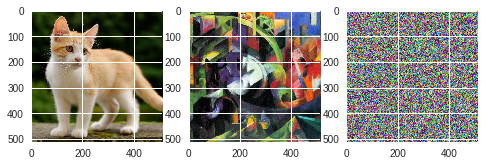

In [16]:
def load_image(fn):
  x = cv2.imread(fn)
  return cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

img_style = load_image('franz-marc-1399594_960_720.jpg')
img_content = load_image('1280px-Golden_tabby_and_white_kitten_n01.jpg')
img_content = img_content[:,200:200+857,:]
img_content = cv2.resize(img_content,(512,512))
img_style = img_style[:,200:200+671,:]
img_style = cv2.resize(img_style,(512,512))

img_result = np.random.randint(256,size=(512,512,3)).astype(np.float64)

fig,ax = plt.subplots(1,3)
ax[0].imshow(img_content)
ax[1].imshow(img_style)
ax[2].imshow(img_result)


In [0]:
from keras import backend as K
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array

In [0]:
img_content_var = K.variable(preprocess_input(np.expand_dims(img_content, axis=0)), dtype='float32')
img_style_var = K.variable(preprocess_input(np.expand_dims(img_style, axis=0)), dtype='float32')
img_result_1 = preprocess_input(np.expand_dims(img_result, axis=0))
img_result_holder = K.placeholder(shape=(1, 512, 512, 3))

## Content Loss

Близость изображения к оригиналу будем определять с помощью функции **content loss**, которая смотрит на промежуточные слои фич изображения при пропускании его через свёрточную сеть, и определяет близость с помощью квадратичного отклонения. Таким образом, на слое $l$ content loss определим как
$$
\mathcal{L}_c = {1\over2}\sum_{i,j} (F_{ij}^{(l)}-P_{ij}^{(l)})^2
$$
где $F^{(l)}$ и $P^{(l)}$ -- значения фич на слое $l$.

In [0]:
def get_feature_reps(x, layer_names, model):
    featMatrices = []
    for ln in layer_names:
        selectedLayer = model.get_layer(ln)
        featRaw = selectedLayer.output
        featRawShape = K.shape(featRaw).eval(session=tf_session)
        N_l = featRawShape[-1]
        M_l = featRawShape[1]*featRawShape[2]
        featMatrix = K.reshape(featRaw, (M_l, N_l))
        featMatrix = K.transpose(featMatrix)
        featMatrices.append(featMatrix)
    return featMatrices

def get_content_loss(F, P):
    cLoss = 0.5*K.sum(K.square(F - P))
    return cLoss

## Style Loss


In [0]:
def get_Gram_matrix(F):
    G = K.dot(F, K.transpose(F))
    return G

def get_style_loss(ws, Gs, As):
    sLoss = K.variable(0.)
    for w, G, A in zip(ws, Gs, As):
        M_l = K.int_shape(G)[1]
        N_l = K.int_shape(G)[0]
        G_gram = get_Gram_matrix(G)
        A_gram = get_Gram_matrix(A)
        sLoss+= w*0.25*K.sum(K.square(G_gram - A_gram))/ (N_l**2 * M_l**2)
    return sLoss
  
def get_total_loss(gImPlaceholder, alpha=1.0, beta=10000.0):
    F = get_feature_reps(gImPlaceholder, layer_names=[content_layer_name], model=gModel)[0]
    Gs = get_feature_reps(gImPlaceholder, layer_names=style_layer_names, model=gModel)
    contentLoss = get_content_loss(F, P)
    styleLoss = get_style_loss(ws, Gs, As)
    totalLoss = alpha*contentLoss + beta*styleLoss
    return totalLoss
 

## Собираем всё вместе

In [0]:
def calculate_loss(gImArr):
  """
  Calculate total loss using K.function
  """
  if gImArr.shape != (1, 512, 512, 3):
        gImArr = gImArr.reshape((1,512, 512, 3))
  loss_fcn = K.function([gModel.input], [get_total_loss(gModel.input)])
  return loss_fcn([gImArr])[0].astype('float64')

def get_grad(gImArr):
  """
  Calculate the gradient of the loss function with respect to the generated image
  """
  if gImArr.shape != (1, 512, 512, 3):
      gImArr = gImArr.reshape((1, 512, 512, 3))
  grad_fcn = K.function([gModel.input], 
                        K.gradients(get_total_loss(gModel.input), [gModel.input]))
  grad = grad_fcn([gImArr])[0].flatten().astype('float64')
  return grad

from keras.applications import VGG16
from scipy.optimize import fmin_l_bfgs_b

tf_session = K.get_session()
cModel = VGG16(include_top=False, weights='imagenet', input_tensor=img_content_var)
sModel = VGG16(include_top=False, weights='imagenet', input_tensor=img_style_var)
gModel = VGG16(include_top=False, weights='imagenet', input_tensor=img_result_holder)

content_layer_name = 'block4_conv2'
style_layer_names = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1']

P = get_feature_reps(x=img_content_var, layer_names=[content_layer_name], model=cModel)[0]
As = get_feature_reps(x=img_style_var, layer_names=style_layer_names, model=sModel)
ws = np.ones(len(style_layer_names))/float(len(style_layer_names))

iterations = 100
x_val = img_result_1.flatten()
xopt, f_val, info= fmin_l_bfgs_b(calculate_loss, x_val, fprime=get_grad,
                            maxiter=iterations, disp=True)

In [0]:
def postprocess_array(x):
    # Zero-center by mean pixel
    if x.shape != (512, 512, 3):
        x = x.reshape((512, 512, 3))
    x[..., 0] += 103.939
    x[..., 1] += 116.779
    x[..., 2] += 123.68
    # 'BGR'->'RGB'
    x = x[..., ::-1]
    x = np.clip(x, 0, 255)
    x = x.astype('uint8')
    return x
  
plt.imshow(postprocess_array(xopt.copy()))

In [14]:
iterations = 100
xopt, f_val, info= fmin_l_bfgs_b(calculate_loss, x_opt, fprime=get_grad,
                            maxiter=iterations, disp=True)
plt.imshow(postprocess_array(xopt.copy()))

KeyboardInterrupt: ignored